In [1]:
# --- Manejo de datos ---
import pandas as pd
import numpy as np
import geopandas as gpd

# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Preprocesamiento ---
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# --- Modelado (Clasificación y Clustering) ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# --- Evaluación de modelos ---
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# --- Configuración general ---
pd.set_option('display.max_columns', None)

# --- Suprimir advertencias ---
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import zscore
from scipy.stats import zscore
import folium

In [5]:
df= pd.read_pickle("data/df_EDA.pkl")

In [5]:
df.info(3)

<class 'pandas.core.frame.DataFrame'>
Index: 8316782 entries, 0 to 8316828
Data columns (total 23 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   case_number           object 
 2   block                 object 
 3   iucr                  object 
 4   primary_type          object 
 5   description           object 
 6   location_description  object 
 7   arrest                int64  
 8   domestic              int64  
 9   beat                  int64  
 10  district              float64
 11  ward                  float64
 12  community_area        float64
 13  fbi_code              object 
 14  x_coordinate          float64
 15  y_coordinate          float64
 16  year                  int64  
 17  latitude              float64
 18  longitude             float64
 19  date_only             object 
 20  time_only             object 
 21  updated_on_only       object 
 22  updated_on_time_only  object 
dtypes: float64(7

In [4]:
df.head(1)

,id,case_number,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,latitude,longitude,date_only,time_only,updated_on_only,updated_on_time_only
0,13311263,JG503434,023XX S TROY ST,1582,OFFENSE INVOLVING CHILDREN,CHILD PORNOGRAPHY,RESIDENCE,1,0,1033,10.0,25.0,30.0,17,1166183.0,1890983.0,2022,41.856422,-87.665619,2022-07-29,03:39:00,2024-04-18,15:40:59


# TTO Outliers

Chicago se encuentra en la latitud 41.85003 y longitud -87.65005. En este sentido comenzaremos a limpiar las variables de coordenadas

¿Qué son X Coordinate y Y Coordinate?
Estas coordenadas se usan en mapas cartográficos para ubicaciones más precisas dentro de un sistema de referencia proyectado, típicamente:

Sistema de referencia: Illinois State Plane NAD83 o similar, en pies o metros.

X Coordinate = distancia este-oeste (easting)

Y Coordinate = distancia norte-sur (northing)

🧭 ¿Cómo se usan?
Estas variables son útiles para análisis espaciales más precisos que requieren proyecciones planas (como mapas de calor, análisis de densidad, o para construir polígonos).

Funcionan mejor cuando usas bibliotecas como GeoPandas, Shapely o herramientas SIG (como QGIS o ArcGIS).

In [6]:
# 1Calcular el Z-Score para cada variable geográfica
df['lat_z'] = zscore(df['latitude'])
df['lon_z'] = zscore(df['longitude'])
df['x_z'] = zscore(df['x_coordinate'])
df['y_z'] = zscore(df['y_coordinate'])

df['outlier'] = (
    (df['lat_z'].abs() > 3) | 
    (df['lon_z'].abs() > 3) |
    (df['x_z'].abs() > 3) |
    (df['y_z'].abs() > 3)
)
print(f"Total de outliers: {df['outlier'].sum()}")

Total de outliers: 32877


Visualización en un Mapa
Una buena forma de analizar la ubicación de los crímenes es visualizar las coordenadas en un mapa. Usando bibliotecas como folium o matplotlib, puedes representar los crímenes sobre un mapa de Chicago

In [23]:
# Crear el mapa centrado en Chicago
map_center = [41.88, -87.63]
m = folium.Map(location=map_center, zoom_start=11)

# 🟥 Dibuja los outliers (en rojo)
for _, row in df[df['outlier']].sample(min(100, df['outlier'].sum()), random_state=42).iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.7,
        popup="Outlier"
    ).add_to(m)

# 🟦 Dibujar puntos normales (en azul, opcional)
for _, row in df[~df['outlier']].sample(100, random_state=1).iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.5
    ).add_to(m)

# Mostrar el mapa
m

In [7]:
df2_clean = df[~df['outlier']].copy()

# Eliminar las columnas auxiliares (Z-Score y 'outlier')
df2_clean.drop(columns=['lat_z', 'lon_z', 'x_z', 'y_z', 'outlier'], inplace=True)

print("Registros después de eliminar outliers:", df2_clean.shape[0])

Registros después de eliminar outliers: 8283905


In [4]:
df2_clean.head(1)

NameError: name 'df2_clean' is not defined

filtro rango valido

In [26]:
LAT_MIN = 41.60
LAT_MAX = 42.10
LON_MIN = -87.80
LON_MAX = -87.50
# Filtrar por rango válido para la ciudad de Chicago
df2_clean = df2_clean[
    (df2_clean['latitude'] >= 41.60) & (df2_clean['latitude'] <= 42.10) &
    (df2_clean['longitude'] >= -87.80) & (df2_clean['longitude'] <= -87.50)
].copy()

print("Registros después del filtro geográfico estricto:", df2_clean.shape[0])

Registros después del filtro geográfico estricto: 8202492


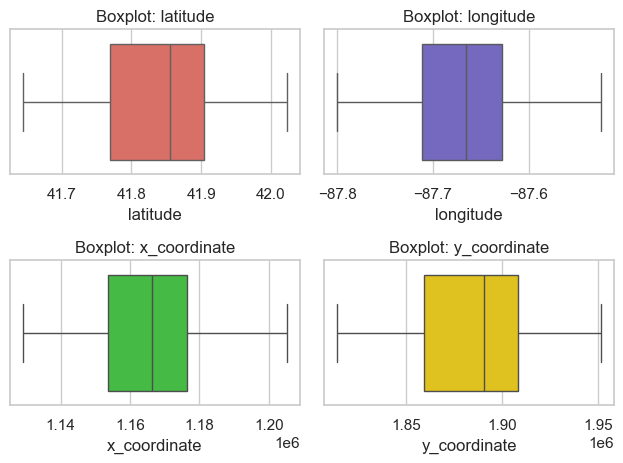

In [27]:
sns.set(style="whitegrid")

variables_geo = ['latitude', 'longitude', 'x_coordinate', 'y_coordinate']

colores = ["#EB6054", '#6A5ACD', '#32CD32', '#FFD700']

for i, col in enumerate(variables_geo, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df2_clean[col], color=colores[i-1])  
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()

plt.show()


In [3]:
df2_clean.info()

NameError: name 'df2_clean' is not defined

# group by

In [29]:
df2_clean['primary_type'].value_counts()

primary_type
THEFT                                1732923
BATTERY                              1500326
CRIMINAL DAMAGE                       930799
NARCOTICS                             757065
ASSAULT                               548643
OTHER OFFENSE                         504616
BURGLARY                              435449
MOTOR VEHICLE THEFT                   417805
DECEPTIVE PRACTICE                    371483
ROBBERY                               310607
CRIMINAL TRESPASS                     219278
WEAPONS VIOLATION                     121790
PROSTITUTION                           70225
OFFENSE INVOLVING CHILDREN             59087
PUBLIC PEACE VIOLATION                 53461
SEX OFFENSE                            33069
CRIM SEXUAL ASSAULT                    27128
INTERFERENCE WITH PUBLIC OFFICER       19707
LIQUOR LAW VIOLATION                   15143
GAMBLING                               14589
ARSON                                  14116
HOMICIDE                               136

In [30]:

crime_mapping = {
    'BATTERY': 'Violencia física',
    'ASSAULT': 'Violencia física',
    'HOMICIDE': 'Violencia física',
    'CRIM SEXUAL ASSAULT': 'Violencia física',
    'CRIMINAL SEXUAL ASSAULT': 'Violencia física',
    'KIDNAPPING': 'Violencia física',
    'STALKING': 'Violencia física',
    'INTIMIDATION': 'Violencia física',
    'DOMESTIC VIOLENCE': 'Violencia física',

    'SEX OFFENSE': 'Violencia sexual',
    'PUBLIC INDECENCY': 'Violencia sexual',
    'OBSCENITY': 'Violencia sexual',

    'THEFT': 'Crímenes contra la propiedad',
    'BURGLARY': 'Crímenes contra la propiedad',
    'MOTOR VEHICLE THEFT': 'Crímenes contra la propiedad',
    'CRIMINAL DAMAGE': 'Crímenes contra la propiedad',
    'ROBBERY': 'Crímenes contra la propiedad',
    'ARSON': 'Crímenes contra la propiedad',
    'DECEPTIVE PRACTICE': 'Crímenes contra la propiedad',

    'NARCOTICS': 'Drogas y alcohol',
    'OTHER NARCOTIC VIOLATION': 'Drogas y alcohol',
    'LIQUOR LAW VIOLATION': 'Drogas y alcohol',

    'INTERFERENCE WITH PUBLIC OFFICER': 'Orden público / gobierno',
    'WEAPONS VIOLATION': 'Orden público / gobierno',
    'CONCEALED CARRY LICENSE VIOLATION': 'Orden público / gobierno',
    'PUBLIC PEACE VIOLATION': 'Orden público / gobierno',
    'GAMBLING': 'Orden público / gobierno',
    'RITUALISM': 'Orden público / gobierno',

    'PROSTITUTION': 'Delitos sexuales comerciales',
    'HUMAN TRAFFICKING': 'Delitos sexuales comerciales',

    'CRIMINAL TRESPASS': 'Otros delitos menores',
    'OTHER OFFENSE': 'Otros delitos menores',
    'OFFENSE INVOLVING CHILDREN': 'Otros delitos menores',

    'NON-CRIMINAL': 'No criminal / administrativo',
    'NON - CRIMINAL': 'No criminal / administrativo',
    'NON-CRIMINAL (SUBJECT SPECIFIED)': 'No criminal / administrativo'
}

# Crear nueva columna con categoría ML
df2_clean['crime_category'] = df2_clean['primary_type'].map(crime_mapping)

# Agrupar por categoría
grouped = df2_clean.groupby('crime_category').size().sort_values(ascending=False)

# Mostrar resultados
print(grouped)


crime_category
Crímenes contra la propiedad    4213182
Violencia física                2118435
Otros delitos menores            782981
Drogas y alcohol                 772363
Orden público / gobierno         210779
Delitos sexuales comerciales      70356
Violencia sexual                  34184
No criminal / administrativo        212
dtype: int64


In [31]:
df2_clean['crime_category'] = df2_clean['primary_type'].map(crime_mapping).fillna('Otros')


# coordenadas y bloque 

quiero oberservar la zona donde se encuenran los puntos de control

In [32]:
df2_clean['block'].value_counts()

block
001XX N STATE ST                       16731
076XX S CICERO AVE                     10677
0000X N STATE ST                       10022
008XX N MICHIGAN AVE                    9690
064XX S DR MARTIN LUTHER KING JR DR     6377
                                       ...  
043XX W Henderson St                       1
058XX S Artesian ave                       1
003XX N Pulaski rd                         1
011XX E 50th ST                            1
043XX N Milwaukee Ave                      1
Name: count, Length: 62955, dtype: int64

In [33]:
grouped = df2_clean.groupby(['block', 'latitude', 'longitude']).size().reset_index(name='count')

In [34]:
# Centrar el mapa (por ejemplo en Chicago)
m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Opcional: mostrar solo los top 100 bloques más activos
top = grouped.sort_values(by='count', ascending=False).head(100)

# Agregar marcadores
for _, row in top.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=min(row['count'] / 500, 15),  # Escala el tamaño
        popup=f"{row['block']}: {row['count']} incidentes",
        color='red',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# Guardar el mapa
m.save('mapa_incidentes.html')

#Escalado de variables

Columnas numericas

In [35]:
# Escalar variables numéricas (por ejemplo, id, beat, ward, etc.)
scaler = StandardScaler()
df2_clean[['id', 'beat', 'ward', 'district', 'community_area']] = scaler.fit_transform(
	df2_clean[['id', 'beat', 'ward', 'district', 'community_area']]
)


In [36]:
df2_clean.head(1)

,id,case_number,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,latitude,longitude,date_only,time_only,updated_on_only,updated_on_time_only,crime_category
0,1.574189,JG503434,023XX S TROY ST,1582,OFFENSE INVOLVING CHILDREN,CHILD PORNOGRAPHY,RESIDENCE,1,0,-0.203672,-0.174828,0.152539,-0.308491,17,1166183.0,1890983.0,2022,41.856422,-87.665619,2022-07-29,03:39:00,2024-04-18,15:40:59,Otros delitos menores


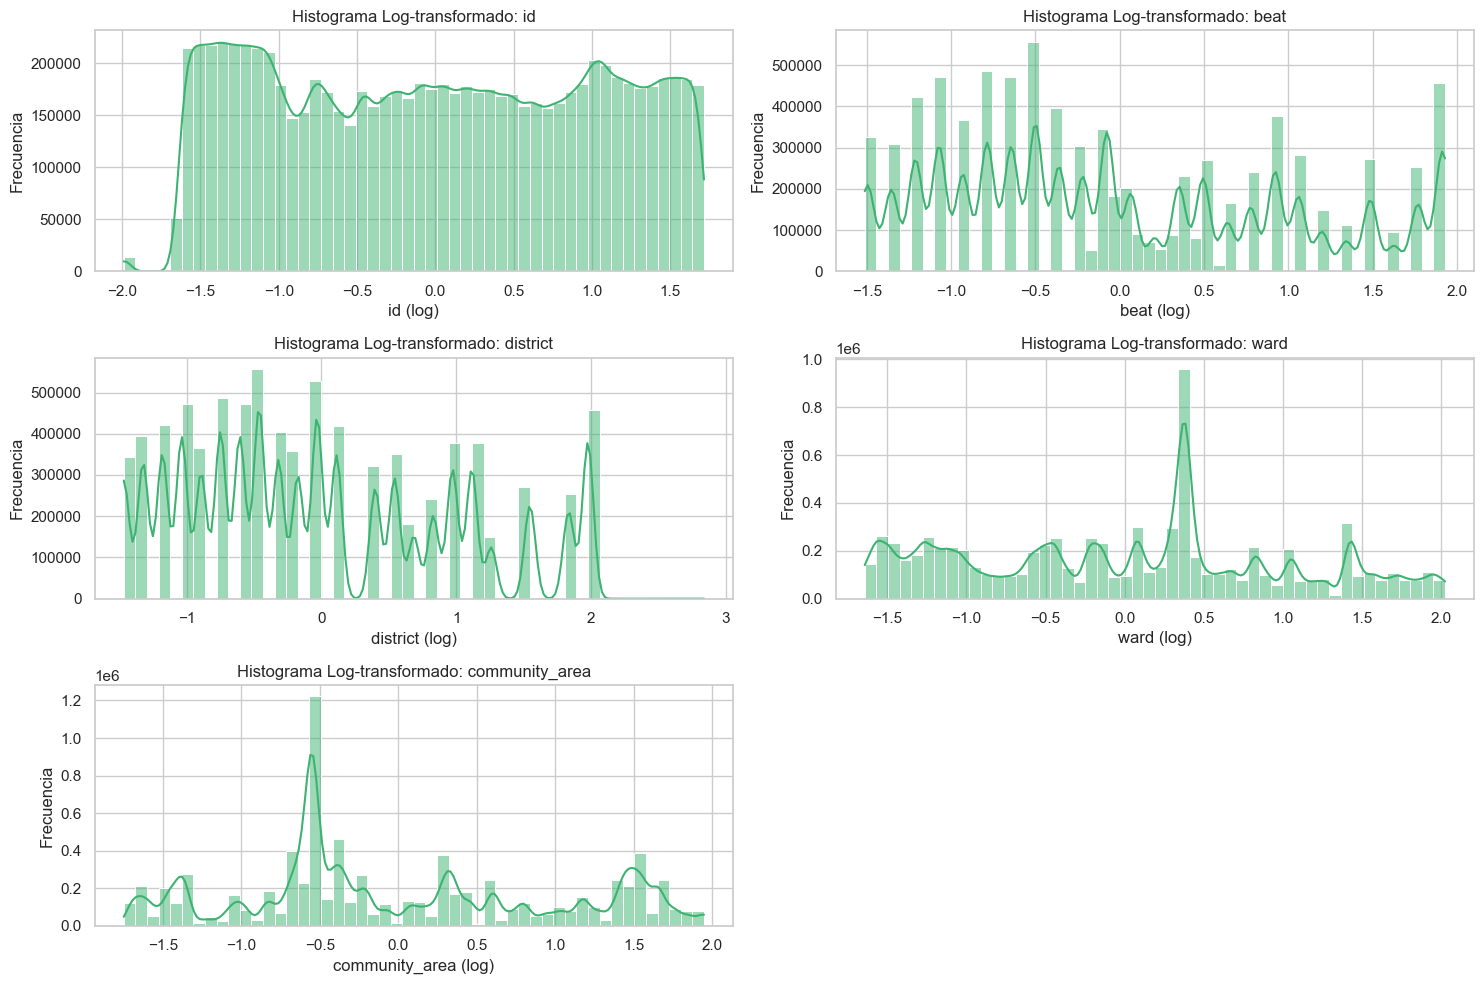

In [37]:
columns_to_plot = ['id', 'beat', 'district', 'ward', 'community_area']

plt.figure(figsize=(15, 10))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df2_clean[col], bins=50, kde=True, color="mediumseagreen")
    plt.title(f'Histograma Log-transformado: {col}')
    plt.xlabel(f'{col} (log)')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


#Codificación de Variables Categóricas con LabelEncoder

In [38]:
label_encoder = LabelEncoder()
df2_clean['crime_category'] = label_encoder.fit_transform(df2_clean['crime_category'])
df2_clean['case_number'] = label_encoder.fit_transform(df2_clean['case_number'])
df2_clean['block'] = label_encoder.fit_transform(df2_clean['block'])

#Usar OneHotEncoding para variables nominales

In [41]:

df2_clean = pd.get_dummies(df2_clean, columns=['location_description', 'fbi_code'], drop_first=True)

MemoryError: Unable to allocate 125. MiB for an array with shape (2, 8202492) and data type int64

In [ ]:
df2_clean.head(1)

,id,case_number,block,iucr,primary_type,description,arrest,domestic,beat,district,ward,community_area,x_coordinate,y_coordinate,year,latitude,longitude,date_only,time_only,updated_on_only,updated_on_time_only,crime_category,location_description_AIRCRAFT,location_description_AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA,location_description_AIRPORT BUILDING NON-TERMINAL - SECURE AREA,location_description_AIRPORT EXTERIOR - NON-SECURE AREA,location_description_AIRPORT EXTERIOR - SECURE AREA,location_description_AIRPORT PARKING LOT,location_description_AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA,location_description_AIRPORT TERMINAL LOWER LEVEL - SECURE AREA,location_description_AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA,location_description_AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA,location_description_AIRPORT TERMINAL UPPER LEVEL - SECURE AREA,location_description_AIRPORT TRANSPORTATION SYSTEM (ATS),location_description_AIRPORT VENDING ESTABLISHMENT,location_description_AIRPORT/AIRCRAFT,location_description_ALLEY,location_description_ANIMAL HOSPITAL,location_description_APARTMENT,location_description_APPLIANCE STORE,location_description_ATHLETIC CLUB,location_description_ATM (AUTOMATIC TELLER MACHINE),location_description_AUTO,location_description_AUTO / BOAT / RV DEALERSHIP,location_description_BANK,location_description_BANQUET HALL,location_description_BAR OR TAVERN,location_description_BARBER SHOP/BEAUTY SALON,location_description_BARBERSHOP,location_description_BASEMENT,location_description_BEACH,location_description_BOAT / WATERCRAFT,location_description_BOAT/WATERCRAFT,location_description_BOWLING ALLEY,location_description_BRIDGE,location_description_CAR WASH,location_description_CASINO/GAMBLING ESTABLISHMENT,location_description_CEMETARY,location_description_CHA APARTMENT,location_description_CHA BREEZEWAY,location_description_CHA ELEVATOR,location_description_CHA GROUNDS,location_description_CHA HALLWAY,location_description_CHA HALLWAY / STAIRWELL / ELEVATOR,location_description_CHA HALLWAY/STAIRWELL/ELEVATOR,location_description_CHA LOBBY,location_description_CHA PARKING LOT,location_description_CHA PARKING LOT / GROUNDS,location_description_CHA PARKING LOT/GROUNDS,location_description_CHA PLAY LOT,location_description_CHA STAIRWELL,location_description_CHURCH,location_description_CHURCH / SYNAGOGUE / PLACE OF WORSHIP,location_description_CHURCH PROPERTY,location_description_CHURCH/SYNAGOGUE/PLACE OF WORSHIP,location_description_CLEANERS/LAUNDROMAT,location_description_CLEANING STORE,location_description_CLUB,location_description_COACH HOUSE,location_description_COIN OPERATED MACHINE,location_description_COLLEGE / UNIVERSITY - GROUNDS,location_description_COLLEGE / UNIVERSITY - RESIDENCE HALL,location_description_COLLEGE/UNIVERSITY GROUNDS,location_description_COLLEGE/UNIVERSITY RESIDENCE HALL,location_description_COMMERCIAL / BUSINESS OFFICE,location_description_CONSTRUCTION SITE,location_description_CONVENIENCE STORE,location_description_COUNTY JAIL,location_description_CREDIT UNION,"location_description_CTA ""L"" PLATFORM","location_description_CTA ""L"" TRAIN",location_description_CTA BUS,location_description_CTA BUS STOP,location_description_CTA GARAGE / OTHER PROPERTY,location_description_CTA PARKING LOT / GARAGE / OTHER PROPERTY,location_description_CTA PLATFORM,location_description_CTA PROPERTY,location_description_CTA STATION,location_description_CTA SUBWAY STATION,location_description_CTA TRACKS - RIGHT OF WAY,location_description_CTA TRAIN,location_description_CURRENCY EXCHANGE,location_description_DAY CARE CENTER,location_description_DELIVERY TRUCK,location_description_DEPARTMENT STORE,location_description_DRIVEWAY,location_description_DRIVEWAY - RESIDENTIAL,location_description_DRUG STORE,location_description_DUMPSTER,location_description_ELEVATOR,location_description_EXPRESSWAY EMBANKMENT,location_description_FACTORY,location_description_FACTORY / MANUFACTURING BUILDING,location_description_F

# Reducción de dimensionalidad

In [ ]:
from sklearn.decomposition import PCA

# PCA para reducir a 2 componentes
pca = PCA(n_components=2)
pca_result = pca.fit_transform(e)

# Guardamos el resultado en un nuevo DataFrame
pca_df = pd.DataFrame(pca_result, columns=['pca1', 'pca2'])

# Clustering no supervisado

In [ ]:
# Variables relevantes para el clustering (crimen)
variables_crimen = ['primary_type', 'iucr', 'location_description']

# Realizamos el clustering de crímenes con K-Means
kmeans_crimen = KMeans(n_clusters=5, random_state=0)
df2_clean['cluster_crimen'] = kmeans_crimen.fit_predict(df2[variables_crimen])

# Ver los primeros registros con el cluster asignado
print(df2_clean[['primary_type', 'iucr', 'location_description', 'cluster_crimen']].head())

   primary_type  iucr  location_description  cluster_crimen
0            24   239                   161               3
1            19   294                   185               0
2             5    15                   116               1
3             6   172                   148               3
4            34    93                   148               4


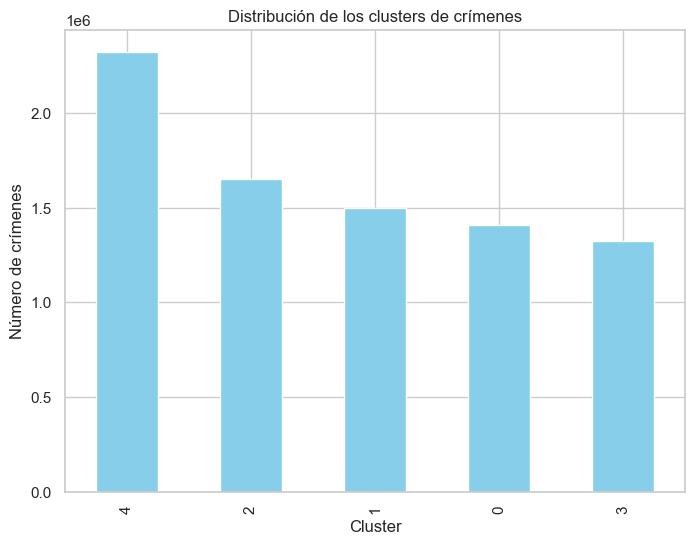

In [ ]:
# Contamos cuántos crímenes hay en cada grupo
cluster_crimen_counts = df2['cluster_crimen'].value_counts()

# Visualizamos la distribución
plt.figure(figsize=(8, 6))
cluster_crimen_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de los clusters de crímenes')
plt.xlabel('Cluster')
plt.ylabel('Número de crímenes')
plt.show()


In [ ]:
import folium
import pandas as pd

# Suponiendo que df2 ya contiene la columna 'cluster_crimen' con los resultados del clustering

# Crear un mapa base centrado en una ubicación promedio
m = folium.Map(location=[df2['latitude'].mean(), df2['longitude'].mean()], zoom_start=12)

# Establecer una paleta de colores para los clusters
colores = ['red', 'blue', 'green', 'purple', 'orange']

# Añadir los crímenes al mapa con colores según el cluster
for _, row in df2.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=colores[int(row['cluster_crimen'])],
        fill=True,
        fill_color=colores[int(row['cluster_crimen'])],
        fill_opacity=0.6,
        popup=f"Tipo: {row['primary_type']}<br>IUCR: {row['iucr']}<br>Descripción: {row['description']}"
    ).add_to(m)

# Guardar el mapa en un archivo HTML
m.save("mapa_crimenes_clusters.html")


Zonas peligrosas (usando K-Means)
Selecciona las variables geográficas (latitude, longitude, community_area, etc.).

Aplica K-Means Clustering sobre las variables geográficas para identificar zonas peligrosas

In [ ]:
# Variables relevantes para las zonas peligrosas (geográficas)
variables_geograficas = ['latitude', 'longitude', 'community_area', 'beat', 'district']

# Realizamos el clustering de las zonas peligrosas con K-Means
kmeans_zonas = KMeans(n_clusters=5, random_state=0)
df2['cluster_zonas'] = kmeans_zonas.fit_predict(df2[variables_geograficas])

# Ver los primeros registros con el cluster asignado
print(df2[['latitude', 'longitude', 'community_area', 'beat', 'district', 'cluster_zonas']].head())

    latitude  longitude  community_area      beat  district  cluster_zonas
0  41.856422 -87.665619        1.489299  2.072063  1.223156              0
1  41.856422 -87.665619        1.457646  2.082407  1.248441              0
2  41.856422 -87.665619        1.503301  1.759956  0.526589              3
3  41.886018 -87.633938        1.503301  1.759956  0.526589              3
4  41.871835 -87.626151        1.503301  1.761349  0.526589              3


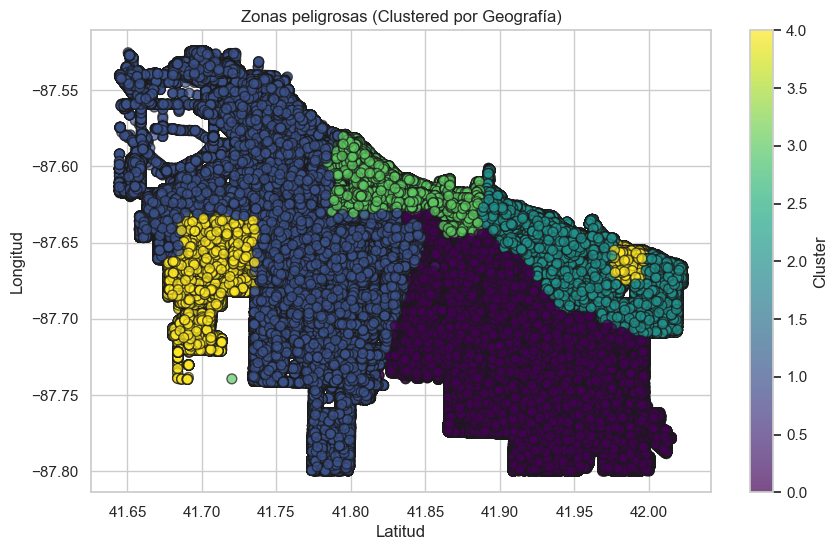

In [ ]:
# Visualizamos las zonas peligrosas en un gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df2['latitude'], df2['longitude'], c=df2['cluster_zonas'], cmap='viridis', s=50, alpha=0.7, edgecolor='k')
plt.title('Zonas peligrosas (Clustered por Geografía)')
plt.xlabel('Latitud')
plt.ylabel('Longitud')
plt.colorbar(label='Cluster')
plt.show()


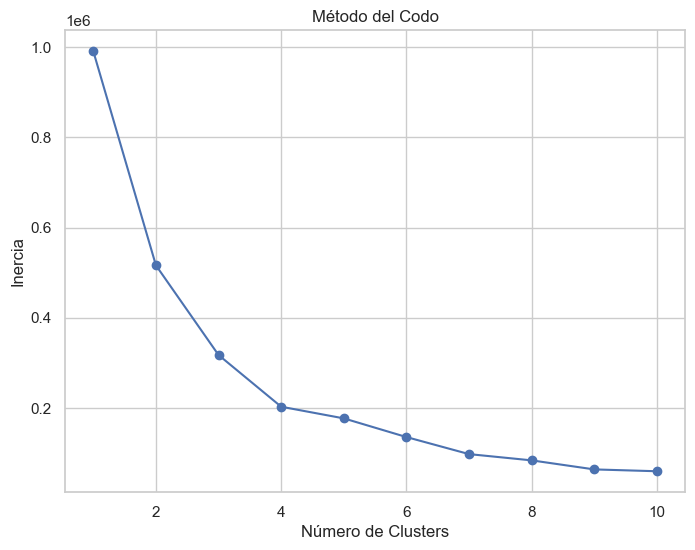

In [ ]:

# El método del codo para encontrar el número óptimo de clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df2[variables_geograficas])  # O variables_crimen para el otro modelo
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()
